In [27]:
from __future__ import print_function
import collections
import os
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Embedding, Flatten, Dropout, TimeDistributed, Reshape, Lambda
from keras.layers import LSTM
from keras.optimizers import RMSprop, Adam, SGD
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import numpy as np
import pdb

In [31]:
train_pathN = "dataset/no_punctuation/1M/wiki_00"
train_pathP = "dataset/cured_text/1M/wiki_00"
valid_pathN = "dataset/no_punctuation/1M/wiki_01"
valid_pathP = "dataset/cured_text/1M/wiki_01"
test_pathN = "dataset/no_punctuation/1M/wiki_02"
test_pathP = "dataset/cured_text/1M/wiki_02"
models_path = "models2"
symbols = [".", "?", "¿", "!", "¡", ",", ":", ";"]

In [32]:
def read_words(filename):
    with tf.gfile.GFile(filename, "r") as f:
        return f.read().replace("\n", " <eos>").split()

In [33]:
print(len(read_words(train_pathN)))
print(len(read_words(train_pathP)))
#read_words(train_pathN)

171127
188953


In [34]:
def build_vocab(filename):
    data = read_words(filename)

    counter = collections.Counter(data)        
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))        

    words, _ = list(zip(*count_pairs))     
    word_to_id = dict(zip(words, range(len(words))))
    
    return word_to_id

In [35]:
def file_to_word_ids(filename, word_to_id):
    data = read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]

In [36]:
def load_data():
    # build the complete vocabulary, then convert text data to list of integers
    word_to_id = build_vocab(train_pathP)
    train_dataN = file_to_word_ids(train_pathN, word_to_id)
    train_dataP = file_to_word_ids(train_pathP, word_to_id)
    valid_dataN = file_to_word_ids(valid_pathN, word_to_id)
    valid_dataP = file_to_word_ids(valid_pathP, word_to_id)
    test_dataN = file_to_word_ids(test_pathN, word_to_id)
    test_dataP = file_to_word_ids(test_pathP, word_to_id)
    vocabulary = len(word_to_id)
    reversed_dictionary = dict(zip(word_to_id.values(), word_to_id.keys()))

    #print(train_data[:5])
    #print(word_to_id)
    #print(vocabulary)
    #print(" ".join([reversed_dictionary[x] for x in train_data[:10]]))
    return train_dataN, train_dataP, valid_dataN, valid_dataP, test_dataN, test_dataP, vocabulary, reversed_dictionary

train_dataN, train_dataP, valid_dataN, valid_dataP, test_dataN, test_dataP, vocabulary, reversed_dictionary = load_data()

In [37]:
print(vocabulary)
print(" ".join([reversed_dictionary[x] for x in train_dataN[100:110]]))
print(" ".join([reversed_dictionary[x] for x in train_dataP[100:110]]))

21543
Sobirá — y por el norte con Francia — con
con España — con las comarcas catalanas de Cerdaña ,


In [38]:
class KerasBatchGenerator(object):

    def __init__(self, dataN, dataP, num_steps, batch_size, vocabulary, skip_step=5):
        self.dataN = dataN
        self.dataP = dataP
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset back to zero
        self.cnt1 = 0
        self.cnt2 = 0
        # skip_step is the number of words which will be skipped before the next batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps))
        y = np.zeros((self.batch_size, self.num_steps, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.cnt1 + self.num_steps >= len(self.dataN):
                    # reset the index back to the start of the data set
                    self.cnt1 = 0
                    self.cnt2 = 0
                x[i, :] = self.dataN[self.cnt1 : self.cnt1 + self.num_steps]
                temp_y = self.dataP[self.cnt2 : self.cnt2 + self.num_steps]
                #global printText
                #if printText:
                #    print("Input text:")
                #    print(" ".join([reversed_dictionary[x] for x in self.dataN[self.cnt1 : self.cnt1 + self.num_steps]]))
                #    print("Expected text:")
                #    print(" ".join([reversed_dictionary[x] for x in self.dataP[self.cnt2 : self.cnt2 + self.num_steps]]))
                
                # convert all of temp_y into a one hot representation
                y[i, :, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                
                self.cnt1 += self.skip_step
                for i in range(self.skip_step):
                    while reversed_dictionary[self.dataP[self.cnt2]] in symbols:                        
                        self.cnt2 += 1
                    self.cnt2 += 1
                
            yield x, y

In [39]:
num_steps = 30
batch_size = 20
#batch_size = 60

train_data_generator = KerasBatchGenerator(train_dataN, train_dataP, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
valid_data_generator = KerasBatchGenerator(valid_dataN, valid_dataP, num_steps, batch_size, vocabulary,
                                           skip_step=num_steps)
hidden_size = 500
use_dropout=True

In [40]:
model = Sequential()
model.add(Embedding(vocabulary, hidden_size, input_length=num_steps))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
if use_dropout:
    model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(vocabulary)))
model.add(Activation('softmax'))

optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
#parallel_model = multi_gpu_model(model, gpus=3)
#parallel_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

print(model.summary())
#print(parallel_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 500)           10771500  
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 500)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 21543)         10793043  
_________________________________________________________________
activation_2 (Activation)    (None, 30, 21543)         0         
Total params: 25,568,543
Trainable params: 25,568,543
Non-trainable params: 0
________________________________________________________________

In [41]:
#1 to train, 2 to test
run_opt = 1
checkpointer = ModelCheckpoint(filepath = models_path + "/model-{epoch:02d}.hdf5", verbose=1)
num_epochs = 100

In [44]:
if run_opt == 1:
    #model = load_model(models_path + "/final_model10M.hdf5")
    history = model.fit_generator(train_data_generator.generate(), len(train_dataP)//(batch_size*num_steps), num_epochsb rabbit factoryb rabbit factoryb rabbit factory,
                        validation_data=valid_data_generator.generate(),
                        validation_steps=len(valid_dataP)//(batch_size*num_steps), callbacks=[checkpointer])
    #parallel_model.save(models_path + "/final_model10MG.hdf5")
    model.save(models_path + "/final_model1M.hdf5")
    #model.save(models_path + "/final_model1M2.hdf5")

Epoch 1/100
314/314 [==============================] - 85s 270ms/step - loss: 7.5021 - categorical_accuracy: 0.0555 - val_loss: 6.7995 - val_categorical_accuracy: 0.0596

Epoch 00001: saving model to models2/model-01.hdf5
Epoch 2/100
314/314 [==============================] - 83s 266ms/step - loss: 7.4627 - categorical_accuracy: 0.0556 - val_loss: 6.5046 - val_categorical_accuracy: 0.0694

Epoch 00002: saving model to models2/model-02.hdf5
Epoch 3/100
314/314 [==============================] - 83s 265ms/step - loss: 7.0166 - categorical_accuracy: 0.0659 - val_loss: 6.4133 - val_categorical_accuracy: 0.0771

Epoch 00003: saving model to models2/model-03.hdf5
Epoch 4/100
314/314 [==============================] - 83s 264ms/step - loss: 6.7998 - categorical_accuracy: 0.0753 - val_loss: 6.3134 - val_categorical_accuracy: 0.0919

Epoch 00004: saving model to models2/model-04.hdf5
Epoch 5/100
314/314 [==============================] - 83s 264ms/step - loss: 6.5683 - categorical_accuracy: 0.1

Epoch 38/100
314/314 [==============================] - 83s 264ms/step - loss: 1.9837 - categorical_accuracy: 0.7655 - val_loss: 4.8872 - val_categorical_accuracy: 0.3583

Epoch 00038: saving model to models2/model-38.hdf5
Epoch 39/100
314/314 [==============================] - 83s 264ms/step - loss: 2.0970 - categorical_accuracy: 0.7545 - val_loss: 4.8285 - val_categorical_accuracy: 0.3601

Epoch 00039: saving model to models2/model-39.hdf5
Epoch 40/100
314/314 [==============================] - 82s 263ms/step - loss: 2.2388 - categorical_accuracy: 0.7340 - val_loss: 4.8202 - val_categorical_accuracy: 0.3592

Epoch 00040: saving model to models2/model-40.hdf5
Epoch 41/100
314/314 [==============================] - 83s 263ms/step - loss: 2.0342 - categorical_accuracy: 0.7566 - val_loss: 4.9761 - val_categorical_accuracy: 0.3573

Epoch 00041: saving model to models2/model-41.hdf5
Epoch 42/100
314/314 [==============================] - 83s 264ms/step - loss: 2.1244 - categorical_accuracy


Epoch 00074: saving model to models2/model-74.hdf5
Epoch 75/100
314/314 [==============================] - 83s 263ms/step - loss: 1.7127 - categorical_accuracy: 0.7947 - val_loss: 5.0673 - val_categorical_accuracy: 0.3580

Epoch 00075: saving model to models2/model-75.hdf5
Epoch 76/100
314/314 [==============================] - 82s 262ms/step - loss: 1.3561 - categorical_accuracy: 0.8382 - val_loss: 5.0612 - val_categorical_accuracy: 0.3683

Epoch 00076: saving model to models2/model-76.hdf5
Epoch 77/100
314/314 [==============================] - 83s 264ms/step - loss: 1.5812 - categorical_accuracy: 0.8141 - val_loss: 5.0435 - val_categorical_accuracy: 0.3652

Epoch 00077: saving model to models2/model-77.hdf5
Epoch 78/100
314/314 [==============================] - 83s 263ms/step - loss: 1.7833 - categorical_accuracy: 0.7879 - val_loss: 4.8741 - val_categorical_accuracy: 0.3544

Epoch 00078: saving model to models2/model-78.hdf5
Epoch 79/100
314/314 [==============================] - 

In [ ]:
if run_opt == 2:
    model = load_model(models_path + "/final_model.hdf5")
    
    example_test_generator = KerasBatchGenerator(valid_dataN, valid_dataP, num_steps, 1, vocabulary,
                                                     skip_step=num_steps)
    printText = False
    dummy_iters = 20
    for i in range(dummy_iters):
        dummy = next(example_test_generator.generate())
    printText = True
    print("Test data:")
    print("###########")
    num_predict = 30
    for i in range(num_predict):        
        data = next(example_test_generator.generate())
        prediction = model.predict(data[0])    
        predict_word = np.argmax(prediction[0, num_steps-1, :])
        s = ""
        aux = 0
        for j in range(num_steps):
            tmp = reversed_dictionary[np.argmax(prediction[0, j, :])]
            if tmp in symbols:
                s += tmp + " "                
            else:
                s += reversed_dictionary[valid_dataN[(dummy_iters+i)*num_steps + aux]] + " "
                aux += 1                            
            
        print("Predicted text:")
        print(s)
        print()

In [45]:
import matplotlib.pyplot as plt

Text(0.5,0,'Epoch')

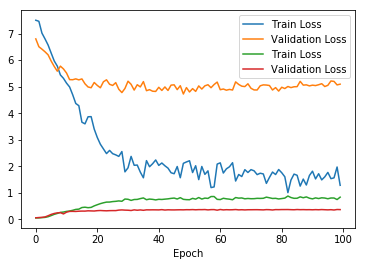

In [48]:


plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0,0.5,'Accuracy')

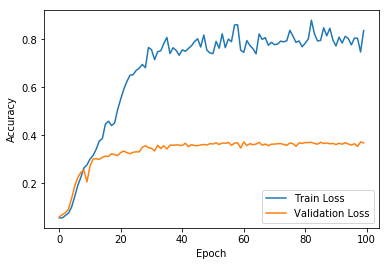

In [49]:
plt.plot(history.history['categorical_accuracy'], label="Train Loss")
plt.plot(history.history['val_categorical_accuracy'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [47]:
history.params

{'epochs': 100,
 'steps': 314,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

In [ ]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [22]:
model = load_model(models_path + "/final_model.hdf5")

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 500)           10771500  
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 500)           2002000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 500)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 21543)         10793043  
_________________________________________________________________
activation_1 (Activation)    (None, 30, 21543)         0         
Total params: 25,568,543
Trainable params: 25,568,543
Non-trainable params: 0
________________________________________________________________